#Tutorial on EMA Workbench, pySD and Vensim
Prepared by Jayendran V (IEOR, IIT Bombay)
(Complete Part 1 (EMA-SEIRBase.ipynb) and Part 2 (EMA-SEIRPolicy.ipynb) of the tutorials before starting with this)
 
##Tutorial Part 3
In Part 3, we will see how to import Vensim model into Python.
EMAWorkbench offers support to directly run Venim Models via Vensim DLL. Unfortunately that will only work in your windows PC (if configured correct).  We will do the following instead:
* Use PySD to convert our Vensim Model into Python model
* Call this python model via EMAworkbench. EMA offers connectors for PySD.

Note that we can directly do experiments using PySD on the imported Vensim model without EMA.


Our first step will be to import our Vensim model into Python.  Since we are using Google Colab, click the folder icon on the left panel.  In the `Files` area, upload your Vensim file. 

###Vensim model: 
A Vensim model (`DMC-OptClass.mdl`) has been built for the "Domestic Manufacturing Company (DMC)" case study described in *Coyle, R.G.(1995), System Dynamics Modelling: A Practical Approach*. The stock flow model is shown in figure below.
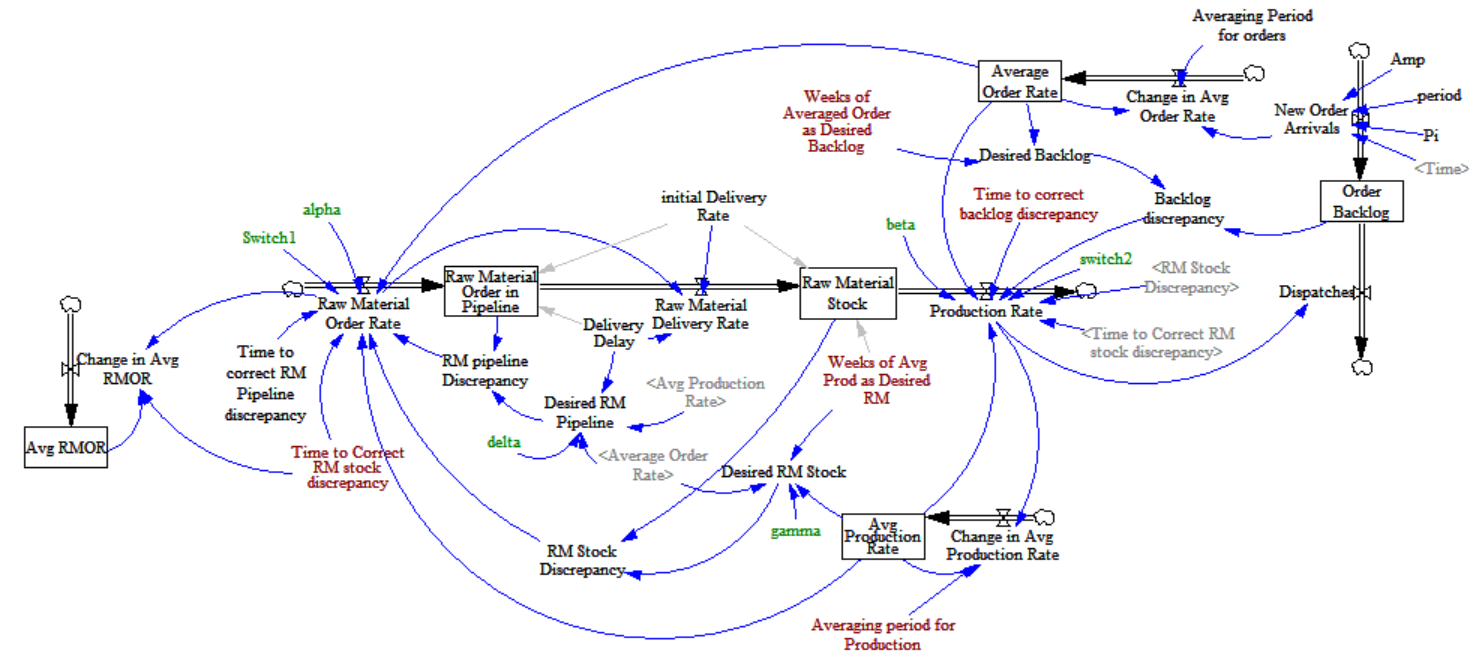


DMC has two key decisions of determining the `Production Rate` and `Raw Material Order Rate`. The company faces a seasonal demand modeled as a sin-wave in `New Order Arrivals`. The model parameters, shown in Red and Green colors in the above figure, are: 'Weeks of Avg Prod as Desired RM', 'Time to Correct RM stock discrepancy', 'Averaging period for Production', 'Averaging period for orders', 'Time to correct backlog discrepancy', 'alpha', 'beta', 'gamma', 'delta', 'Switch1', 'switch2'. There are a total of 12 parameters.

The objective (or desired behavior) of the systems is given as follows:
* Make RM stock come closer to Desired RM stock
* Ensure backlog doesn’t move away from desired backlog
* Avoid unneccesary fluctuations in Production Rate
* Bring RM Order Rate under control

The objectives are captured by the following stock-flow structure within the model.

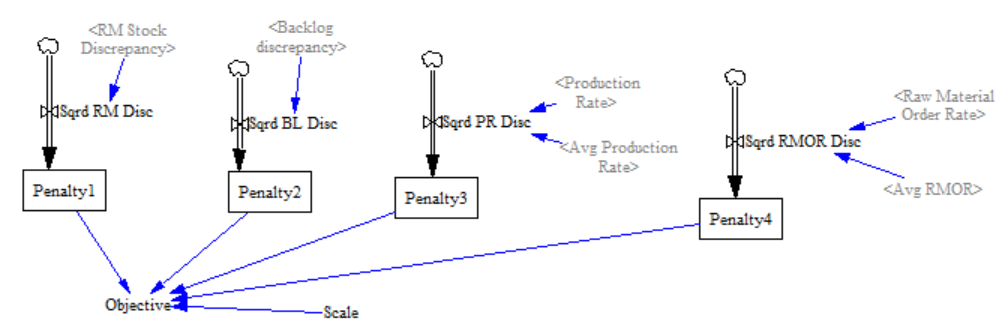

##pySD
Install the pySD package.  pySD is an open course package. More details on PySD can be found at https://pysd.readthedocs.io/en/master/ or you can get more detailed tutorials from its github page.

In [1]:
!pip -q install pySD

     |████████████████████████████████| 80 kB 8.2 MB/s 
     |████████████████████████████████| 141 kB 66.9 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 747 kB 51.0 MB/s 
     |████████████████████████████████| 743 kB 58.6 MB/s 


In [2]:
import numpy as np
import pandas as pd
import pysd
import matplotlib.pyplot as plt

vmodel = pysd.read_vensim('DMC-OptClass.mdl')

You can see that the above `read_vensim()` function has created a 'DMC-OptClass.py' file. This is the python code for the Vensim model.

Now, let's run the model and plot the results.

In [3]:
# The run() function, called without parameters will with default values in the Vensim file.
SD_result = vmodel.run()

time = SD_result.index.values

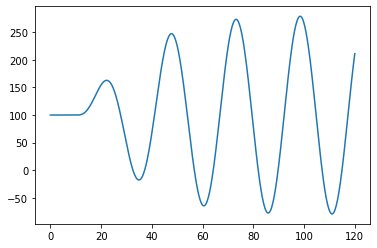

In [4]:
plt.plot(time,  SD_result['Raw Material Order Rate'])

We can also specify/ change parameters are run the model, as shown:

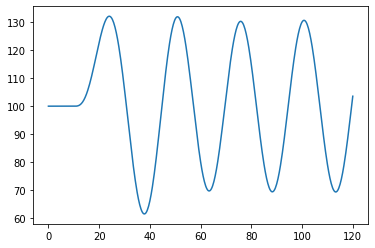

In [5]:
SD_result = vmodel.run(params={ 'Weeks of Avg Prod as Desired RM':4,
                                    'Time to Correct RM stock discrepancy': 8,
                                    'Averaging period for Production': 8})
plt.plot(time,  SD_result['Raw Material Order Rate'],)

The SD_results for each variable is stored as a series. Let's take a look at 'Objective'.  You can simply give the timed index to extract the value at that point.

In [6]:
print(SD_result['Objective'])
print('Value at time 119.25 is ' , SD_result['Objective'][119.25])
print('Value at time 120 is ' , SD_result['Objective'][120])

0.00       0.000000
0.25       0.000000
0.50       0.000000
0.75       0.000000
1.00       0.000000
            ...    
119.00    11.566880
119.25    11.569635
119.50    11.571484
119.75    11.572798
120.00    11.573957
Name: Objective, Length: 481, dtype: float64
Value at time 119.25 is  11.569634923215732
Value at time 120 is  11.573956816629885


You can further explore the use of pySD on your own. 

Let's move on to EMA.

In [7]:
!pip -q install ema_workbench

     |████████████████████████████████| 23.7 MB 1.2 kB/s 


First, let us define a function that will run the model using pysd.

In [8]:
vmodel = pysd.read_vensim('DMC-OptClass.mdl')

def runPySdModel(wap, ato, atp, tabl, tarm, alpha, gamma, delta, beta, switch1, switch2):
  SD_result = vmodel.run(params={ 
      'Weeks of Avg Prod as Desired RM':wap,
      'Time to Correct RM stock discrepancy': tarm,
      'Averaging period for Production': atp,
      'Averaging period for orders':ato,
      'Time to correct backlog discrepancy':tabl,
      'alpha':alpha,
      'beta':beta,
      'gamma':gamma,
      'delta':delta,
      'Switch1':switch1,
      'switch2':switch2}, 
      return_columns=['Raw Material Order Rate', 'Production Rate', 'Penalty1', 'Penalty2', 'Penalty3', 'Penalty4', 'Objective'])
  
  endPenalty1=SD_result['Penalty1'][120]
  endPenalty2=SD_result['Penalty2'][120]
  endPenalty3=SD_result['Penalty3'][120]
  endPenalty4=SD_result['Penalty4'][120]
  endObj=SD_result['Objective'][120]

  time = SD_result.index.values
  return (time, SD_result['Raw Material Order Rate'], SD_result['Production Rate'], endPenalty1, endPenalty2, endPenalty3, endPenalty4, endObj)


Next, specify the EMA Wrapper

In [9]:
from ema_workbench import (Model, RealParameter, CategoricalParameter, ScalarOutcome, TimeSeriesOutcome)

myVmodel = Model('runPySdModel', function=runPySdModel)  # instantiate the model

# specify uncertainties
myVmodel.uncertainties = [RealParameter("wap", 2, 10),
                          RealParameter("ato", 2, 10),
                          RealParameter("atp", 2, 10),
                          RealParameter("tabl", 2, 10),
                          RealParameter("tarm", 2, 10),
                          RealParameter("alpha", 0, 1),
                          RealParameter("gamma", 0, 1),
                          RealParameter("delta", 0, 1),
                          RealParameter("beta", 0, 1),
                          CategoricalParameter("switch1", [0, 1]),
                          CategoricalParameter("switch2", [0, 1])
                          ]

# specify outcomes
myVmodel.outcomes = [TimeSeriesOutcome('Time'),
                    TimeSeriesOutcome('RMOR'),
                    TimeSeriesOutcome('PR'),
                     ScalarOutcome('Penalty1'),
                     ScalarOutcome('Penalty2'),
                     ScalarOutcome('Penalty3'),
                     ScalarOutcome('Penalty4'),
                     ScalarOutcome('Obj')]


/usr/local/lib/python3.7/dist-packages/ema_workbench/em_framework/evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
/usr/local/lib/python3.7/dist-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


And then, run the experiments

In [10]:
#Run the model using EMA for 100 scenarios
import time
from ema_workbench import ema_logging, perform_experiments, MultiprocessingEvaluator

start = time.time()

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(myVmodel) as evaluator:
  results = evaluator.perform_experiments(scenarios=100)

print("It has taken ", time.time() - start, " seconds to complete all experiments")


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


It has taken  36.80155658721924  seconds to complete all experiments


It may be a good idea to save the simulation results, so that we can import the same later if needed.

In [ ]:
from ema_workbench import save_results
save_results(results, 'DMC500.tar.gz')

#from ema_workbench import load_results
#results = load_results('')

[MainProcess/INFO] results saved successfully to /content/DMC500.tar.gz


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[MainProcess/INFO] Penalty1 not shown because it is not time series data
[MainProcess/INFO] Penalty2 not shown because it is not time series data
[MainProcess/INFO] Penalty3 not shown because it is not time series data
[MainProcess/INFO] Penalty4 not shown because it is not time series data
[MainProcess/INFO] Obj not shown because it is not time series data


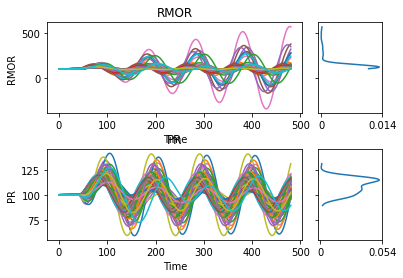

In [11]:
from ema_workbench.analysis import plotting, plotting_util
experiments, outcomes = results
#show lines, and end state density
figure=plotting.lines(experiments, outcomes, outcomes_to_show=['RMOR', 'PR'] ,density=plotting_util.Density.KDE) 


Now that we have the experiment results, we can do a variety of analysis as disucssed in EMA Tutorial Part 1 and Part 2. For instance, we can do feature scoring to see the relative importance of variables.

In [12]:
#Feature Scoring
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes['Obj']

fs, _ = feature_scoring.get_rf_feature_scores(x,y,mode=feature_scoring.RuleInductionType.REGRESSION)
fs

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


,1
0,
gamma,0.424852
tarm,0.165654
alpha,0.071907
switch2,0.066557
delta,0.060842
wap,0.052695
switch1,0.042502
tabl,0.036165
ato,0.032507


Using EMA toolbox, we can explore the search space, and perhaps suggest parameter settings that will result in a low objective value.